# 重新实现之前的线性热模型
应该只需要读取第一次实验的数据，这里主要想规范一下之前的写法

In [1]:
import pandas as pd
import numpy as np
import os
from keys import *
import math

from tqdm import tqdm
from loader import Loader
from thermal_model.data import *
from thermal_model.configs import *
from thermal_model.figure_plotter import *
from utils_thermal_model_raw_process import *
import matplotlib.pyplot as plt
from plotter import Plotter
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lars
from sklearn.ensemble import RandomForestRegressor
from thermal_model.thermal_model import fit_random_forest, model_estimator,fit_LARS
import pickle
import math
from thermal_model.electrolyzer import Electrolyzer
from thermal_model.original_thermal_model_and_plotter_0117 import current_TlyeIn_TlyeOut


# 读取数据并且缓存成单独pickle

In [ ]:
df_thermal_model_data_raw = ThermalModelData().load()

# 生成线性模型的输入项

In [ ]:
df_thermal_model_data_input = generate_model_input(df_thermal_model_data_raw)

In [ ]:
df_thermal_model_data_input.columns

# 生成模型（应该使用线性模型）

In [ ]:
model_random_forest,model_input,model_target = fit_random_forest(df_thermal_model_data_input,6)

In [ ]:
( model_predict, error) = model_estimator(
    model_random_forest,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="随机森林",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="随机森林"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict
).save()

In [ ]:
model_lars,model_input,model_target = fit_LARS(df_thermal_model_data_input)

In [ ]:
( model_predict, error) = model_estimator(
    model_lars,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="LARS",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="LARS"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict,
    title_model='LARS'
).save()

# 测试模型功能

figure saved at Thermal model 不同碱液入口温度下电解槽出入口温度差


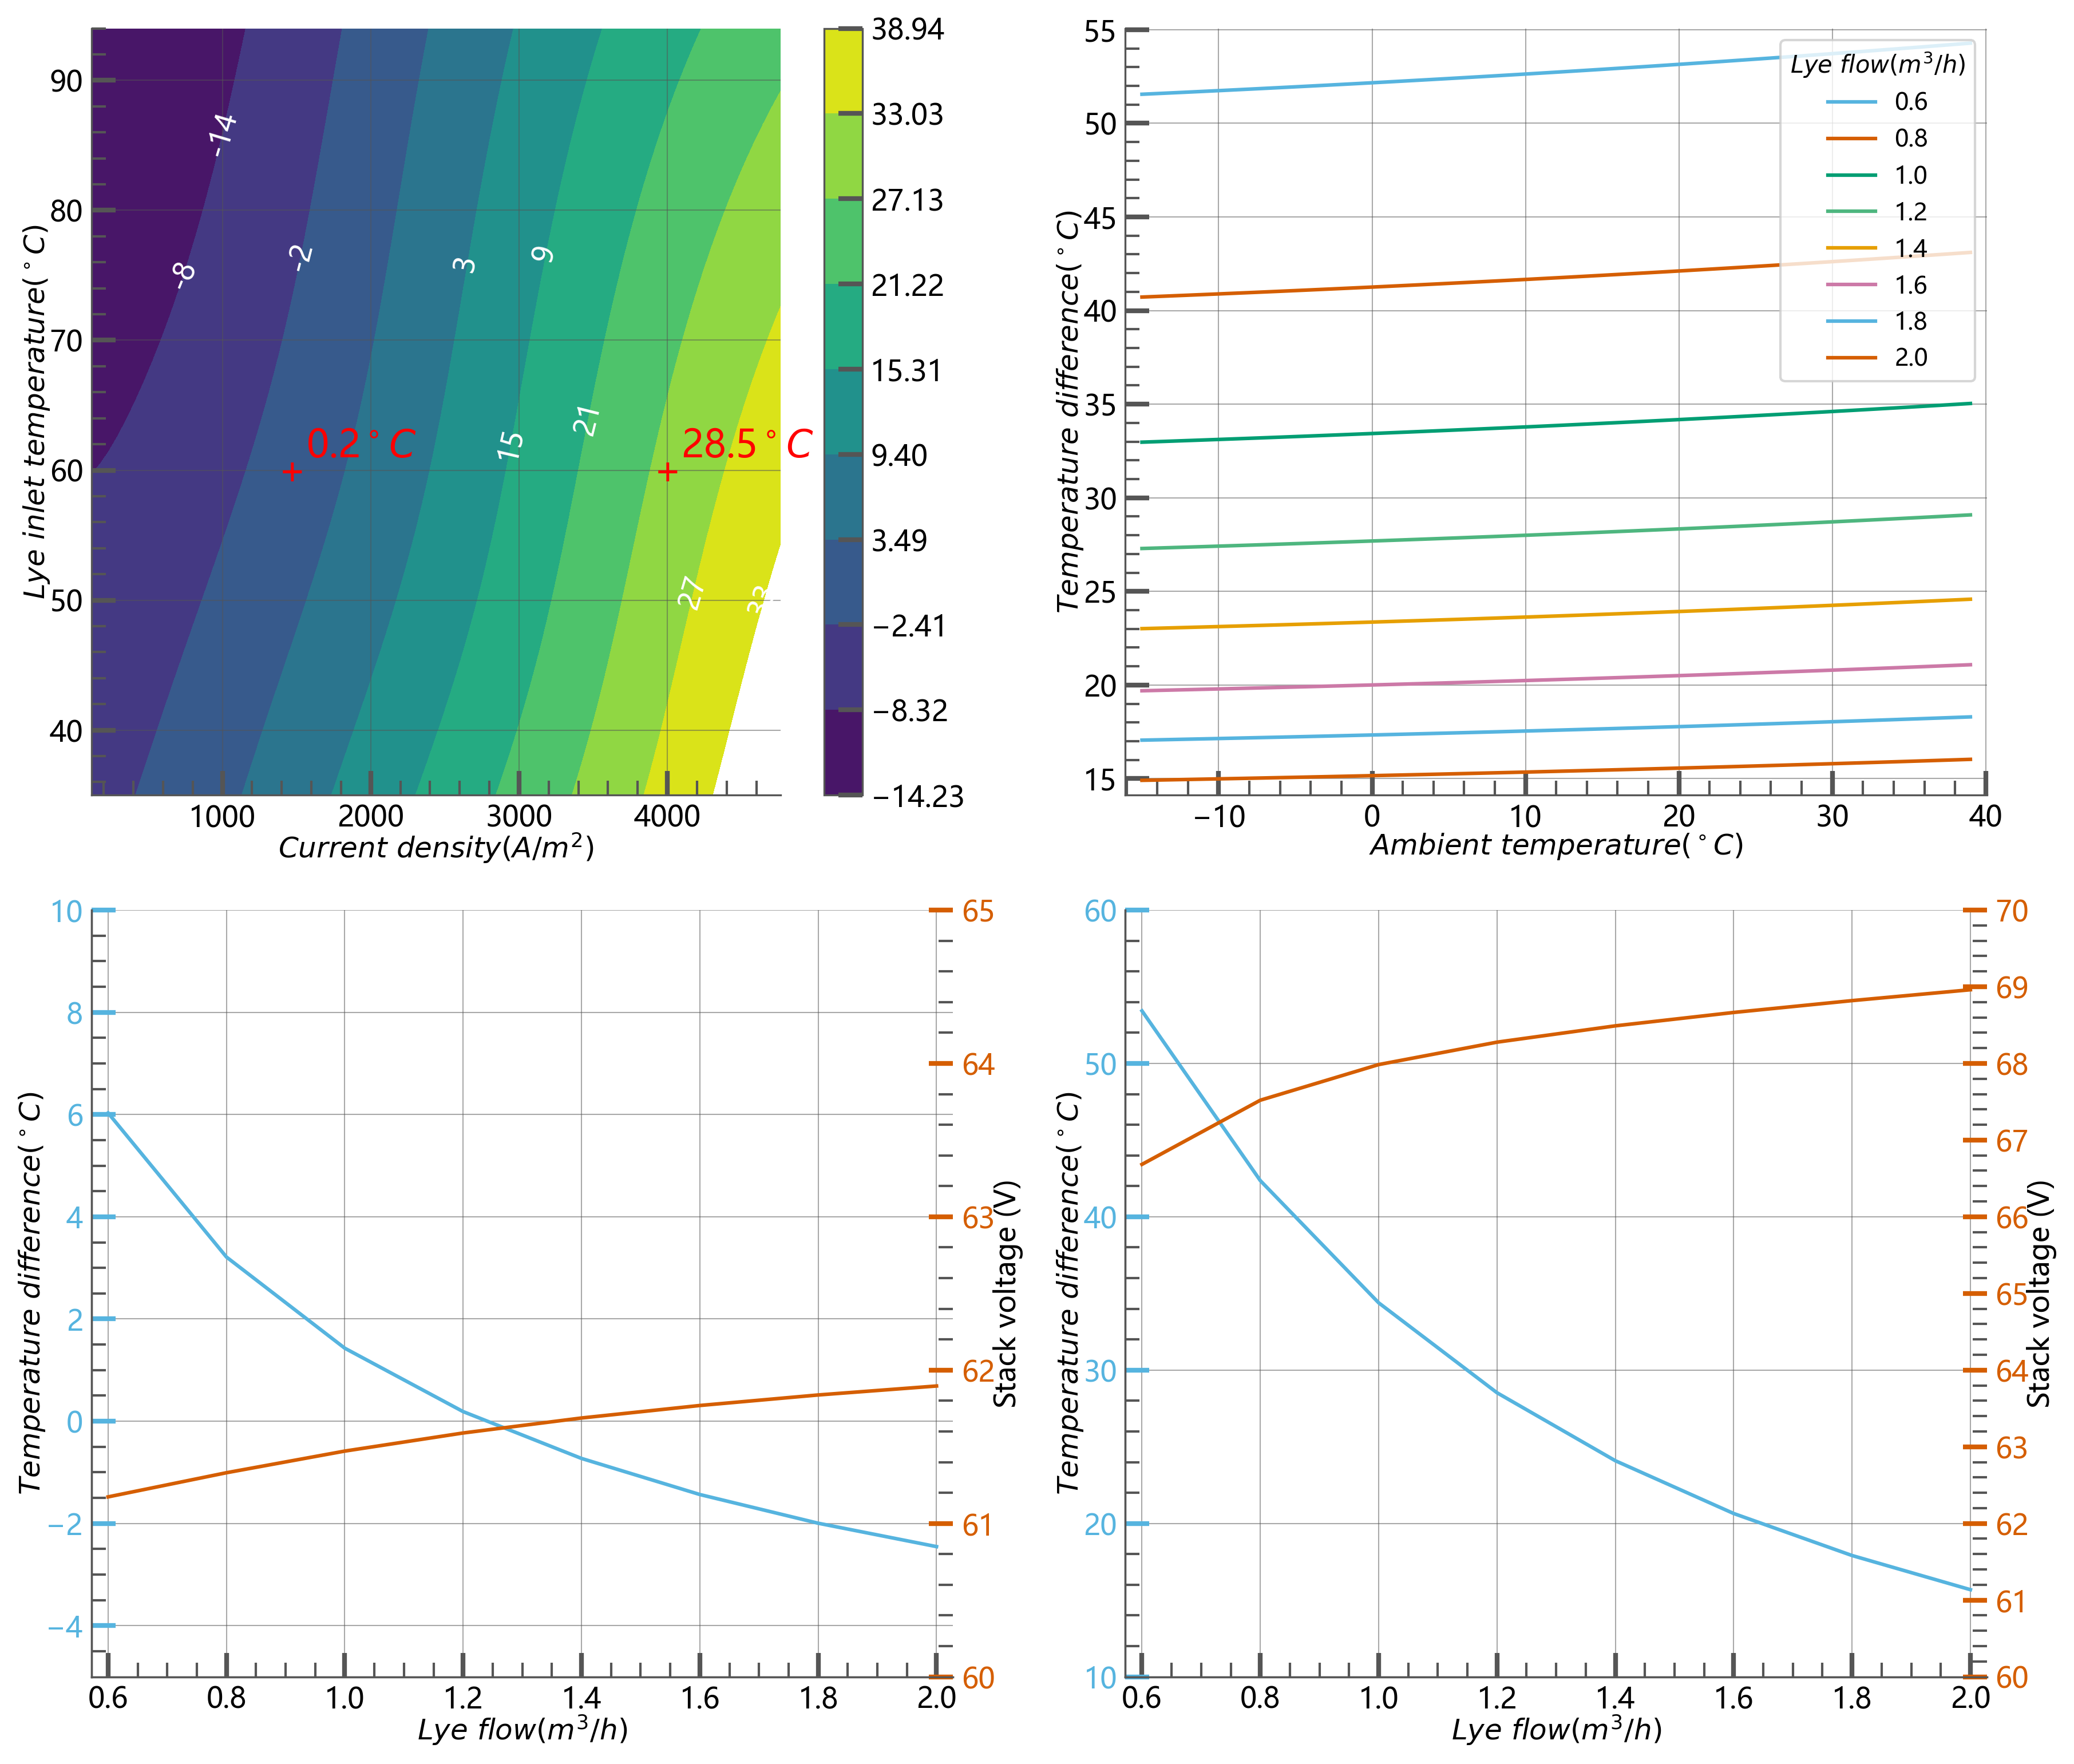

In [2]:
Model_output_input_temperature_delta().save()

In [ ]:
current_TlyeIn_TlyeOut()

In [ ]:
lye_flow_range = np.arange(0.6,2.1,0.1)
current = OperatingCondition.Optimal.current
lye_temperature = OperatingCondition.Optimal.lye_temperature
temperature_list = []

for lye_flow in lye_flow_range:
    temperature_cur = electrolyzer.temperature_thermal_balance_current(
        ambient_temperature= electrolyzer.default_ambient_temperature,
        lye_flow= lye_flow,
        lye_temperature = lye_temperature,
        current=current
    )
    temperature_list.append(temperature_cur)
plt.plot(
    lye_flow_range,
    temperature_list
)
plt.xlabel(r'$Lye\ flow (m^3/h)$')
plt.ylabel(r'$Outlet temperature (^\circ C)$')

In [ ]:
plt.show()

In [ ]:
(
    current_list,
    voltage_list,
    power_list,
    temperature_list
) = electrolyzer.get_default_polarization()

In [ ]:
electrolyzer.temperature_thermal_balance_current(
    ambient_temperature=15,
    lye_flow=1.5,
    lye_temperature=10,
    current=0
)